In [1]:
import posixpath
import pandas as pd
import geopandas as gpd
import shapely
import numpy as np
from shapely.geometry import Polygon
from shapely import plotting
import matplotlib.pyplot as plt
import datetime
import scipy
import distances

## Load datasets and count glaciers

In [2]:
data_root = "D:/OneDrive/Documents/Cours/4A/SFE/data/"

kh_fronts = gpd.read_file(posixpath.join(data_root, "KH-5_ARGON_fronts/KH-5_ARGON_fronts.shp")).to_crs(epsg=25833)
kh_fronts.head()

,image,mission,timestamp,RGI60ID,RGI70ID,front_id,front_dir,geometry
0,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00777,RGI2000-v7.0-G-07-01225,3,E,"LINESTRING (447461.671 8832029.666, 447497.042..."
1,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00775,RGI2000-v7.0-G-07-01229,4,SE,"LINESTRING (446131.469 8835920.477, 446232.529..."
2,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00709,RGI2000-v7.0-G-07-00011,25,W,"LINESTRING (416080.008 8819152.093, 416146.96 ..."
3,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00664,RGI2000-v7.0-G-07-00015,26,W,"LINESTRING (415736.404 8813938.659, 415733.877..."
4,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00663,RGI2000-v7.0-G-07-00016,27,W,"LINESTRING (417320.52 8806789.925, 417358.417 ..."


In [3]:
landsat_fronts = gpd.read_file(posixpath.join(data_root, "Landsat_MSS_fronts/Landsat_MSS_fronts.shp")).to_crs(epsg=25833)
landsat_fronts.head()

,image,mission,timestamp,RGI60ID,RGI70ID,front_id,front_dir,geometry
0,LM02_L1GS_245002_19760505_20200907_02_T2,Landsat 2 MSS,1976-05-05,RGI60-07.00791,RGI2000-v7.0-G-07-01223,2,NE,"LINESTRING (446917.357 8830600.499, 446900.231..."
1,LM02_L1GS_245002_19760505_20200907_02_T2,Landsat 2 MSS,1976-05-05,RGI60-07.00777,RGI2000-v7.0-G-07-01225,3,E,"LINESTRING (447150.28 8832426.203, 447136.579 ..."
2,LM02_L1GS_245002_19760505_20200907_02_T2,Landsat 2 MSS,1976-05-05,RGI60-07.00775,RGI2000-v7.0-G-07-01229,4,SE,"LINESTRING (446105.553 8836403.019, 446122.679..."
3,LM02_L1GS_245002_19760505_20200907_02_T2,Landsat 2 MSS,1976-05-05,RGI60-07.00794,RGI2000-v7.0-G-07-01268,5,NE,"LINESTRING (445687.662 8843966.161, 445629.431..."
4,LM02_L1GS_245002_19760505_20200907_02_T2,Landsat 2 MSS,1976-05-05,RGI60-07.00790,RGI2000-v7.0-G-07-01266,6,NE,"LINESTRING (442212.658 8844269.303, 442116.749..."


In [4]:
all_fronts = pd.concat([kh_fronts, landsat_fronts], ignore_index=True)
all_fronts.head()

,image,mission,timestamp,RGI60ID,RGI70ID,front_id,front_dir,geometry
0,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00777,RGI2000-v7.0-G-07-01225,3,E,"LINESTRING (447461.671 8832029.666, 447497.042..."
1,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00775,RGI2000-v7.0-G-07-01229,4,SE,"LINESTRING (446131.469 8835920.477, 446232.529..."
2,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00709,RGI2000-v7.0-G-07-00011,25,W,"LINESTRING (416080.008 8819152.093, 416146.96 ..."
3,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00664,RGI2000-v7.0-G-07-00015,26,W,"LINESTRING (415736.404 8813938.659, 415733.877..."
4,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00663,RGI2000-v7.0-G-07-00016,27,W,"LINESTRING (417320.52 8806789.925, 417358.417 ..."


In [5]:
print(len(all_fronts.RGI70ID.value_counts()), "glaciers observed")
print(len(all_fronts.front_id.value_counts()), "fronts observed")

167 glaciers observed
181 fronts observed


## Uncertainties and results with a personal method to measure front displacements

### First test on a specific front

In [6]:
fronts_i = all_fronts.loc[all_fronts.front_id == 141]
fronts_i

,image,mission,timestamp,RGI60ID,RGI70ID,front_id,front_dir,geometry
52,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.01554,RGI2000-v7.0-G-07-01531,141,NE,"LINESTRING (706193.565 8667750.728, 706858.008..."
110,DS09058A024MC013,KH-5 ARGON 9058A,1963-08-29,RGI60-07.01554,RGI2000-v7.0-G-07-01531,141,NE,"LINESTRING (713675.271 8637225.816, 713845.731..."
715,LM02_L1GS_224004_19760712_20200907_02_T2,Landsat 2 MSS,1976-07-12,RGI60-07.01554,RGI2000-v7.0-G-07-01531,141,NE,"LINESTRING (700538.395 8663991.175, 700557.27 ..."
727,LM02_L1GS_228003_19760716_20200907_02_T2,Landsat 2 MSS,1976-07-16,RGI60-07.01554,RGI2000-v7.0-G-07-01531,141,NE,"LINESTRING (701120.513 8663051.852, 701013.526..."
743,LM02_L1GS_230003_19760718_20200907_02_T2,Landsat 2 MSS,1976-07-18,RGI60-07.01554,RGI2000-v7.0-G-07-01531,141,NE,"LINESTRING (700836.202 8663548.992, 700863.965..."


area : 68609359.55143876 distance : 1032.4789928686012
distance from dot prod : -1702.3486011934392 , direction : -1.0


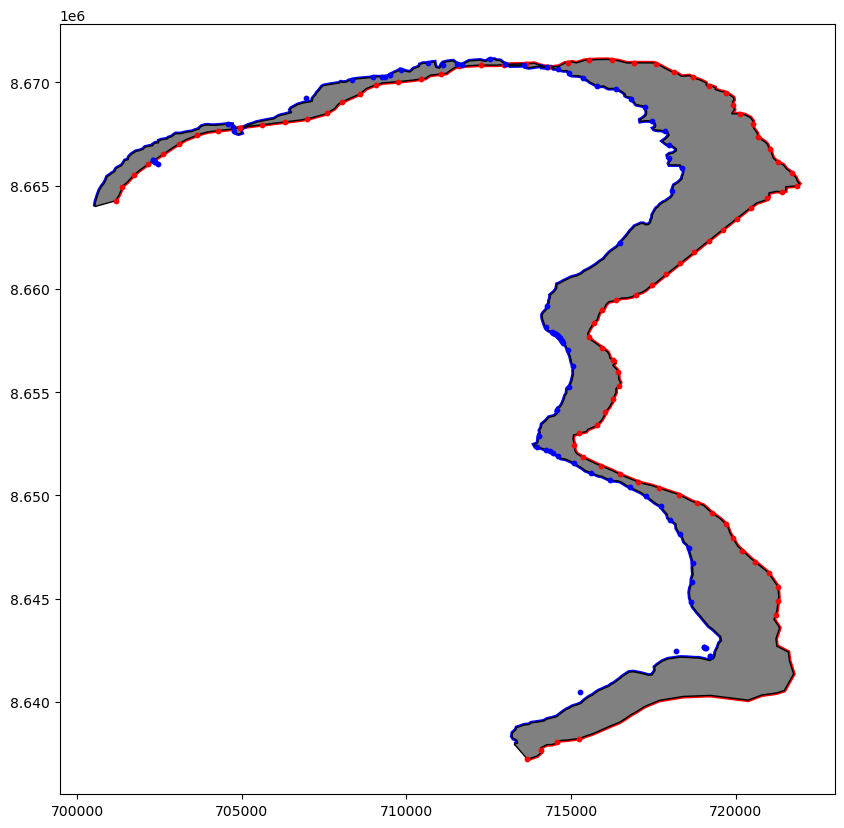

In [7]:
i1, i2 = 1, 2

front1, front2 = fronts_i.iloc[i1].geometry, fronts_i.iloc[i2].geometry
dir1, dir2 = fronts_i.iloc[i1].front_dir, fronts_i.iloc[i2].front_dir
u = np.array([1, 1]) / np.sqrt(2)

## absolute distance
# print("length imbalance :", np.abs(front1.length - front2.length)/np.min([front1.length, front2.length]))
# polygon1 = Polygon(list(front1.coords) + list(front2.coords))
# area1 = polygon1.area
# polygon2 = Polygon(list(front1.coords) + list(front2.coords)[::-1])
# area2 = polygon2.area
# print("area imbalance :", np.abs(area1 - area2)/np.max([area1, area2]))
# d1 = area1/((front1.length + front2.length)/2)
# d2 = area2/((front1.length + front2.length)/2)
# print("distances :", d1, d2)

points_1 = [shapely.Point(coords) for coords in front1.coords]
points_2 = [shapely.Point(coords) for coords in front2.coords]

if shapely.distance(points_1[0], points_2[0]) > shapely.distance(points_1[0], points_2[-1]):
    points_2 = points_2[::-1]
    front2 = shapely.LineString(points_2)
    
polygon = shapely.Polygon(list(front1.coords) + list(front2.coords[::-1]))
area = polygon.area
d = area / ((front1.length + front2.length) / 2)
print("area :", area, "distance :", d)

## direction
# middle of extreme points → not working
# c1 = (np.array(front1.coords)[0] + np.array(front1.coords)[-1])/2
# c2 = (np.array(front2.coords)[0] + np.array(front2.coords)[-1])/2

# centroids → works but a lot of rejections
# c1 = np.array([shapely.centroid(front1).x, shapely.centroid(front1).y])
# c2 = np.array([shapely.centroid(front2).x, shapely.centroid(front2).y])

# center of the font → not working well
# c1 = np.array([front1.interpolate(0.5 * front1.length).x, front1.interpolate(0.5 * front1.length).y])
# c2 = np.array([front2.interpolate(0.5 * front2.length).x, front2.interpolate(0.5 * front2.length).y])

# dot_prod = np.dot(c2-c1, u)#/ np.linalg.norm(c2-c1)
# sgn = np.sign(dot_prod)
# print("dot product :", dot_prod, "sign :", sgn)

# center of the front1 + using flow direction → probably the best solution
points_interp_1 = pd.DataFrame(
    [],
    columns=["points", "x", "y"]
)
points_interp_1.loc[:, "points"] = front1.interpolate(np.linspace(0, front1.length, 100))
points_interp_1.loc[:, ["x", "y"]] = np.stack([np.array([points_interp_1.points.iloc[i].x, points_interp_1.points.iloc[i].y]) for i in range(100)], axis=0)
ll = shapely.MultiLineString([np.stack([points_interp_1.loc[:, ["x", "y"]].iloc[i] - u * 50000, points_interp_1.loc[:, ["x", "y"]].iloc[i] + u * 50000])for i in range(100)])
points_interp_2 = pd.DataFrame(
    [],
    columns=["points", "x", "y"]
)
for i in range(len(points_interp_1)):
    l = ll.geoms[i]
    point_interp_2_i = shapely.intersection(front2, l)
    
    if point_interp_2_i.is_empty:
        points_interp_2.loc[len(points_interp_2), ["points", "x", "y"]] = [None, None, None]
        
    elif isinstance(point_interp_2_i, shapely.Point):
        points_interp_2.loc[len(points_interp_2), ["points", "x", "y"]] = [point_interp_2_i, point_interp_2_i.x, point_interp_2_i.y]
    
    elif isinstance(point_interp_2_i, shapely.MultiPoint):
        point_interp_2_i = np.array([np.array([pt.x, pt.y]) for pt in point_interp_2_i.geoms]).mean(axis=0)
        point_interp_2_i = shapely.Point(point_interp_2_i)
        points_interp_2.loc[len(points_interp_2), ["points", "x", "y"]] = [point_interp_2_i, point_interp_2_i.x, point_interp_2_i.y]

points_interp = pd.concat([points_interp_1, points_interp_2], axis=1)
points_interp.columns = ["points_1", "x1", "y1", "points_2", "x2", "y2"]
points_interp.dropna(inplace=True)

# points_interp
points_interp.loc[:, "x21"] = points_interp.loc[:, "x2"] - points_interp.loc[:, "x1"]
points_interp.loc[:, "y21"] = points_interp.loc[:, "y2"] - points_interp.loc[:, "y1"]
dot_prod = points_interp.loc[:, ["x21", "y21"]].apply(lambda z: z.x21 * u[0] + z.y21 * u[1], axis=1)
points_interp.loc[:, "dot_prod"] = dot_prod
sgn = np.sign(points_interp.dot_prod.mean())

print("distance from dot prod :", dot_prod.mean() , ", direction :", sgn)

## plots
# fig, axs = plt.subplots(ncols=2, figsize=[10, 6])
# shapely.plotting.plot_line(front1, color="red", add_points=False, linewidth=3, ax=axs[0])
# shapely.plotting.plot_line(front2, color="blue", add_points=False, linewidth=3, ax=axs[0])
# shapely.plotting.plot_polygon(polygon1, facecolor="gray", edgecolor="k", add_points=False, ax=axs[0])
# # axs[0].scatter(c1[0], c1[1], color="red")
# # axs[0].scatter(c2[0], c2[1], color="blue")
# # shapely.plotting.plot_points(c1_s, color="red", ax=axs[0])
# # shapely.plotting.plot_points(c2_s, color="blue", ax=axs[0])
# axs[0].scatter(points_interp.x1, points_interp.y1, color="red", s=10, label="front 1")
# axs[0].scatter(points_interp.x2, points_interp.y2, color="blue", s=10, label="front 2")

# shapely.plotting.plot_line(front1, color="red", add_points=False, linewidth=3, ax=axs[1])
# shapely.plotting.plot_line(front2, color="blue", add_points=False, linewidth=3, ax=axs[1])
# shapely.plotting.plot_polygon(polygon2, facecolor="gray", edgecolor="k", add_points=False, ax =axs[1])
# # axs[1].scatter(c1[0], c1[1], color="red")
# # axs[1].scatter(c2[0], c2[1], color="blue")
# # shapely.plotting.plot_points(c1_s, color="red", ax=axs[1])
# # shapely.plotting.plot_points(c2_s, color="blue", ax=axs[1])
# axs[1].scatter(points_interp.x1, points_interp.y1, color="red", s=10, label="front 1")
# axs[1].scatter(points_interp.x2, points_interp.y2, color="blue", s=10, label="front 2")

fig, ax = plt.subplots(figsize=[10, 10])
shapely.plotting.plot_line(front1, color="red", add_points=False, linewidth=3, ax=ax)
shapely.plotting.plot_line(front2, color="blue", add_points=False, linewidth=3, ax=ax)
shapely.plotting.plot_polygon(polygon, facecolor="gray", edgecolor="k", add_points=False, ax=ax)
ax.scatter(points_interp.x1, points_interp.y1, color="red", s=10, label="front 1")
ax.scatter(points_interp.x2, points_interp.y2, color="blue", s=10, label="front 2")

### Uncertainties

KH

Timestamp: 1962-05-16 00:00:00, Mean distance: -18.14 m, Standard deviation: 539.68 m
Timestamp: 1963-08-29 00:00:00, Mean distance: -24.31 m, Standard deviation: 225.01 m
Skipped 40 (2 direction and 38 length) comparisons out of 516.


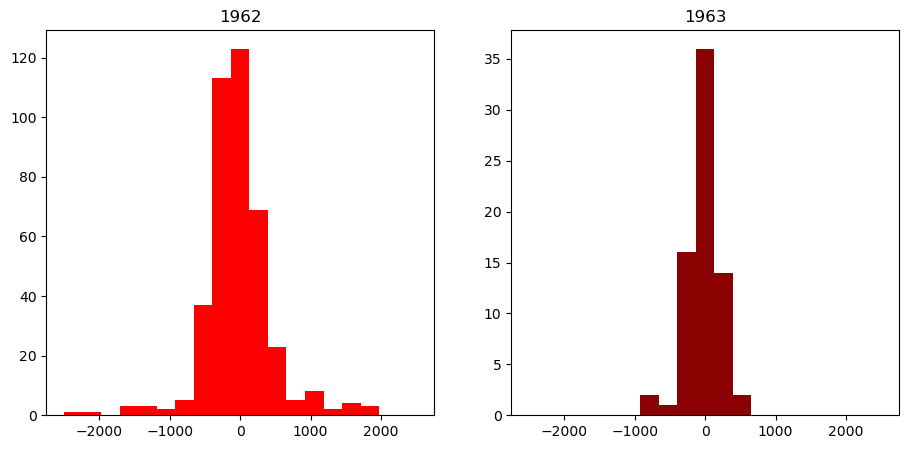

In [8]:
dists = []
skip_count_len = 0
skip_count_dir = 0
total_count = 0
timestamps = [datetime.datetime(1962, 5, 16), datetime.datetime(1963, 8, 29)]
for timestamp in timestamps:
    dists_timestamp = []
    front_ids = kh_fronts.loc[kh_fronts.timestamp == timestamp].front_id.unique()
    for i_front_id, front_id in enumerate(front_ids):
        fronts = kh_fronts.loc[kh_fronts.front_id == front_id].loc[kh_fronts.timestamp == timestamp]
        for k in range(len(fronts.geometry) - 1):
            for l in range(k + 1, len(fronts.geometry)):
                front1 = fronts.geometry.iloc[k]
                front2 = fronts.geometry.iloc[l]
                dir_1 = fronts.front_dir.iloc[k]
                dir_2 = fronts.front_dir.iloc[l]
                dist, e = distances.distance(front1, front2, dir_1, dir_2)
                if dist == np.nan:
                    print(f"Warning: NaN distance for front_id {front_id}, timestamp {timestamp}, indices {k}, {l}")
                if dist is not None:
                    dists_timestamp.append(dist)
                elif e == 1:
                    skip_count_len += 1
                elif e == 2:
                    skip_count_dir += 1
                total_count += 1
    dists.append(dists_timestamp)
        
dists_npy = [np.array(dists_timestamp) for dists_timestamp in dists]
sigma_kh = [dists_npy_timestamp.std() for dists_npy_timestamp in dists_npy]
mean = [dists_npy_timestamp.mean() for dists_npy_timestamp in dists_npy]

for i in range(len(timestamps)):
    print(f"Timestamp: {timestamps[i]}, Mean distance: {mean[i]:.2f} m, Standard deviation: {sigma_kh[i]:.2f} m")

print(f"Skipped {skip_count_len + skip_count_dir} ({skip_count_dir} direction and {skip_count_len} length) comparisons out of {total_count}.")
fig, axs = plt.subplots(ncols=len(timestamps), figsize=(11, 5))
axs[0].hist(dists[0], bins=np.linspace(-2500, 2500, 20), color="red")
axs[0].set_title(timestamps[0].strftime("%Y"))
axs[1].hist(dists[1], bins=np.linspace(-2500, 2500, 20), color="darkred")
axs[1].set_title(timestamps[1].strftime("%Y"))
# fig.suptitle("Distribution of distances between KH-5 ARGON fronts")
fig.savefig("images/KH-5_ARGON_fonts_accuracy.png", bbox_inches="tight")

Landsat

Year: 1976, Mean distance: -8.96 m, Standard deviation: 80.70 m
Year: 1978, Mean distance: 16.64 m, Standard deviation: 117.93 m
Skipped 59 (0 direction and 59 length) comparisons out of 337.


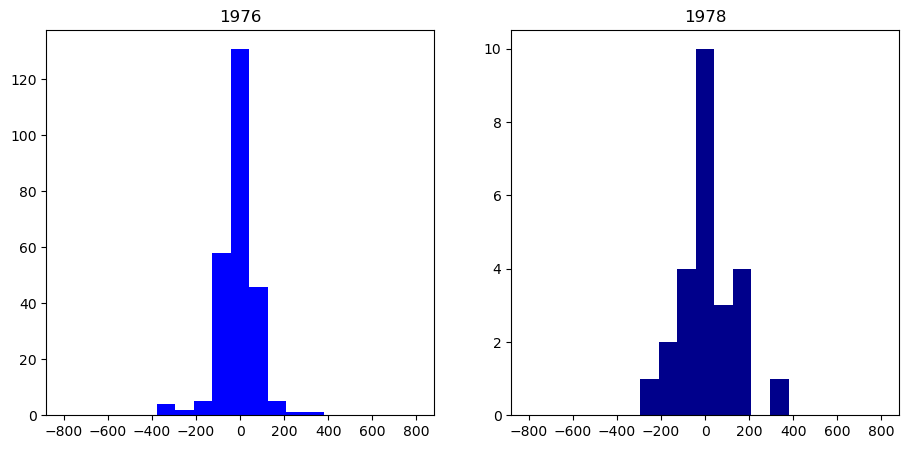

In [9]:
def get_year(timestamp):
    return timestamp.year

dists = []
skip_count_len = 0
skip_count_dir = 0
total_count = 0
years = [1976, 1978]
for year in years:
    dists_year = []
    front_ids = landsat_fronts.loc[landsat_fronts.timestamp.apply(get_year) == year].front_id.unique()
    for front_id in front_ids:
        fronts = landsat_fronts.loc[landsat_fronts.front_id == front_id].loc[landsat_fronts.timestamp.apply(get_year) == year]
        for k in range(len(fronts.geometry) - 1):
            for l in range(k + 1, len(fronts.geometry)):
                front1 = fronts.geometry.iloc[k]
                front2 = fronts.geometry.iloc[l]
                dir_1 = fronts.front_dir.iloc[k]
                dir_2 = fronts.front_dir.iloc[l]
                dist, e = distances.distance(front1, front2, dir_1, dir_2)
                if dist is not None:
                    dists_year.append(dist)
                elif e == 1:
                    skip_count_len += 1
                elif e == 2:
                    skip_count_dir += 1
                total_count += 1
    dists.append(dists_year)
        
dists_npy = [np.array(dists_year) for dists_year in dists]
sigma_landsat = [dists_npy_year.std() for dists_npy_year in dists_npy]
mean = [dists_npy_year.mean() for dists_npy_year in dists_npy]

for i in range(len(years)):
    print(f"Year: {years[i]}, Mean distance: {mean[i]:.2f} m, Standard deviation: {sigma_landsat[i]:.2f} m")

print(f"Skipped {skip_count_len + skip_count_dir} ({skip_count_dir} direction and {skip_count_len} length) comparisons out of {total_count}.")
fig, axs = plt.subplots(ncols=len(years), figsize=(11, 5))
axs[0].hist(dists[0], bins=np.linspace(-800, 800, 20), color="blue")
axs[0].set_title(years[0])
axs[1].hist(dists[1], bins=np.linspace(-800, 800, 20), color="darkblue")
axs[1].set_title(years[1])
# fig.suptitle("Distribution of distances between Landsat MSS fronts")
fig.savefig("images/Landsat_MSS_fonts_accuracy.png", bbox_inches="tight")

Recompile uncertainties

In [10]:
years = np.array([1962, 1963, 1976, 1978])
sigmas_prime = np.floor(np.concatenate([sigma_kh, sigma_landsat]))
sigmas = np.floor(sigmas_prime / np.sqrt(2))
print(sigmas_prime, sigmas)

[539. 225.  80. 117.] [381. 159.  56.  82.]


In [23]:
uncertainties = pd.DataFrame(
    [],
    columns=["year_1", "year_2", "sigma_dist", "2_sigma_dist", "3_sigma_dist"]
)

for i in range(len(years) - 1):
    for j in range(i, len(years)):
        uncertainties.loc[len(uncertainties)] = [
            years[i],
            years[j],
            np.sqrt(sigmas[i]**2 + sigmas[j]**2),
            2 * np.sqrt(sigmas[i]**2 + sigmas[j]**2),
            3 * np.sqrt(sigmas[i]**2 + sigmas[j]**2)
        ]
    
uncertainties = uncertainties[["year_1", "year_2", "sigma_dist", "2_sigma_dist", "3_sigma_dist"]]
uncertainties

,year_1,year_2,sigma_dist,2_sigma_dist,3_sigma_dist
0,1962.0,1962.0,709.935208,1419.870417,2129.805625
1,1962.0,1963.0,545.710546,1091.421092,1637.131638
2,1962.0,1976.0,510.909973,1021.819945,1532.729918
3,1962.0,1978.0,511.476295,1022.952589,1534.428884
4,1963.0,1963.0,302.641702,605.283405,907.925107
5,1963.0,1976.0,234.138848,468.277695,702.416543
6,1963.0,1978.0,235.372046,470.744092,706.116138
7,1976.0,1976.0,134.350288,268.700577,403.050865
8,1976.0,1978.0,136.488095,272.976189,409.464284


In [26]:
uncertainties.to_csv("./uncertainties_manual.csv", index=False)

## Box method

### First tests

In [12]:
all_fronts.head()

,image,mission,timestamp,RGI60ID,RGI70ID,front_id,front_dir,geometry
0,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00777,RGI2000-v7.0-G-07-01225,3,E,"LINESTRING (447461.671 8832029.666, 447497.042..."
1,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00775,RGI2000-v7.0-G-07-01229,4,SE,"LINESTRING (446131.469 8835920.477, 446232.529..."
2,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00709,RGI2000-v7.0-G-07-00011,25,W,"LINESTRING (416080.008 8819152.093, 416146.96 ..."
3,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00664,RGI2000-v7.0-G-07-00015,26,W,"LINESTRING (415736.404 8813938.659, 415733.877..."
4,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00663,RGI2000-v7.0-G-07-00016,27,W,"LINESTRING (417320.52 8806789.925, 417358.417 ..."


In [13]:
boxes = gpd.read_file(posixpath.join(data_root, "boxes/boxes.shp")).to_crs(epsg=25833)
boxes.head()

,front_id,front_dir,RGI60ID,RGI70ID,geometry
0,1,NE,RGI60-07.01494,RGI2000-v7.0-G-07-00054,"POLYGON ((448958.093 8831407.133, 451132.965 8..."
1,2,NE,RGI60-07.00791,RGI2000-v7.0-G-07-01223,"POLYGON ((448556.464 8831393.624, 447609.196 8..."
2,3,E,RGI60-07.00777,RGI2000-v7.0-G-07-01225,"POLYGON ((446223.949 8833013.329, 449012.234 8..."
3,4,SE,RGI60-07.00775,RGI2000-v7.0-G-07-01229,"POLYGON ((445849.929 8838239.577, 448611.174 8..."
4,5,NE,RGI60-07.00794,RGI2000-v7.0-G-07-01268,"POLYGON ((444478.132 8842149.605, 443352.455 8..."


In [14]:
fronts_i = all_fronts.loc[all_fronts.front_id == 52]
fronts_i

,image,mission,timestamp,RGI60ID,RGI70ID,front_id,front_dir,geometry
25,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00465,RGI2000-v7.0-G-07-00354,52,E,"LINESTRING (482907.211 8713010.646, 482911.001..."
81,DS09058A024MC013,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00465,RGI2000-v7.0-G-07-00354,52,E,"LINESTRING (482953.714 8712928.344, 483061.461..."
243,DS09034A008MC022,KH-5 ARGON 9034A,1962-05-16,RGI60-07.00465,RGI2000-v7.0-G-07-00354,52,E,"LINESTRING (483353.81 8712332.201, 483280.998 ..."
627,LM02_L1GS_239002_19760709_20200907_02_T2,Landsat 2 MSS,1976-07-09,RGI60-07.00465,RGI2000-v7.0-G-07-00354,52,E,"LINESTRING (482828.179 8713133.73, 482861.804 ..."
634,LM02_L1GS_240002_19760710_20200907_02_T2,Landsat 2 MSS,1976-07-10,RGI60-07.00465,RGI2000-v7.0-G-07-00354,52,E,"LINESTRING (482862.657 8713011.896, 482866.66 ..."
833,LM03_L1GS_238003_19780812_20210611_02_T2,Landsat 3 MSS,1978-08-12,RGI60-07.00465,RGI2000-v7.0-G-07-00354,52,E,"LINESTRING (482704.683 8713062.28, 482768.992 ..."


[[ 487855.85190003 8713300.19571801]
 [ 481422.78938224 8711594.19018843]] [8713300.19571801 8711594.19018843]
Distance between fronts 0 and 3 is -584.09 m, with area1 = 3727731.88 m^2, area2 = 2738724.35 m^2, base length = 1693.25 m.


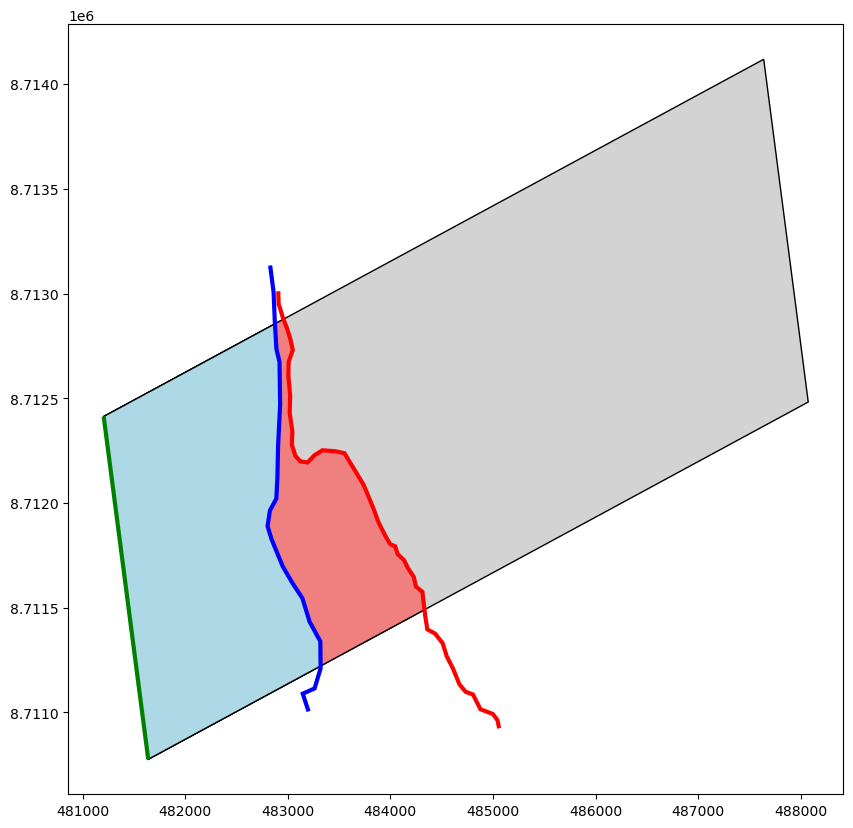

In [15]:
ia, ib = 0, 3

front1, front2 = fronts_i.iloc[ia].geometry, fronts_i.iloc[ib].geometry
dir1, dir2 = fronts_i.iloc[ia].front_dir, fronts_i.iloc[ib].front_dir
u = np.array([0, 1])
box = boxes.loc[boxes.front_id == fronts_i.iloc[ia].front_id].geometry.values[0]

inter1, inter2 = shapely.intersection(front1, box.exterior), shapely.intersection(front2, box.exterior)
if isinstance(inter1, shapely.Point):
    inter1 = shapely.MultiPoint([inter1])
if isinstance(inter2, shapely.Point):
    inter2 = shapely.MultiPoint([inter2])
    
assert(not inter1.is_empty), "Intersection of front 1 with the box is empty."
assert(not inter2.is_empty), "Intersection of front 2 with the box is empty."
    
assert(len(list(inter1.geoms)) >= 2), "Intersection of front 1 with the box should be a line."
assert(len(list(inter2.geoms)) >= 2), "Intersection of front 2 with the box should be a line."

# method 1 : dot product with points 1 by 1: doesn't work
# box_points = np.array([[shapely.Point(coords).x, shapely.Point(coords).y] for coords in box.exterior.coords])[:-1, :]
# u_dot_box = np.sum(box_points * np.stack([u, u, u, u], axis=0), axis=1)
# print(box_points)
# print(u_dot_box)

# i1 = np.argmin(u_dot_box, axis=0)
# u_dot_box_cpy = np.copy(u_dot_box)
# u_dot_box_cpy[i1] = np.inf
# i2 = np.argmin(u_dot_box_cpy, axis=0)

# base_points = np.stack([box_points[i1], box_points[i2]])


# method 2 : intersection with fronts + dot product with u: works!
box_sides = [shapely.LineString([box.exterior.coords[i], box.exterior.coords[i + 1]]) for i in range(len(box.exterior.coords) - 1)]
possible_base = [box_sides[i] for i in range(len(box_sides)) if not shapely.intersects(box_sides[i], front1)]
possible_base_centers = np.array([[shapely.centroid(possible_base[i]).x, shapely.centroid(possible_base[i]).y] for i in range(len(possible_base))])
u_dot_c = np.sum(possible_base_centers * np.stack([u, u], axis=0), axis=1)

base = possible_base[np.argmin(u_dot_c)]
print(possible_base_centers, u_dot_c)
# base_points = np.array([[shapely.Point(coords).x, shapely.Point(coords).y] for coords in base.coords])


# cropped fronts
front1_crop = shapely.intersection(front1, box)
front2_crop = shapely.intersection(front2, box)

if isinstance(front1_crop, shapely.MultiLineString):
    lines = [shapely.LineString(line) for line in front1_crop.geoms]
    front1_crop = lines[np.argmax([line.length for line in lines])]
if isinstance(front2_crop, shapely.MultiLineString):
    lines = [shapely.LineString(line) for line in front2_crop.geoms]
    front2_crop = lines[np.argmax([line.length for line in lines])]

# distance
points_1 = [shapely.Point(coords) for coords in front1_crop.coords]
points_2 = [shapely.Point(coords) for coords in front2_crop.coords]
base_points = [shapely.Point(coords) for coords in base.coords]

if shapely.distance(points_1[0], base_points[0]) > shapely.distance(points_1[0], base_points[-1]):
    points_1 = points_1[::-1]
    front1_crop = shapely.LineString(points_1)
    
if shapely.distance(points_2[0], base_points[0]) > shapely.distance(points_2[0], base_points[-1]):
    points_2 = points_2[::-1]
    front2_crop = shapely.LineString(points_2)
    
polygon1 = shapely.Polygon(list(front1_crop.coords) + list(base.coords[::-1]))
polygon2 = shapely.Polygon(list(front2_crop.coords) + list(base.coords[::-1]))
area1 = polygon1.area
area2 = polygon2.area
d = (area2 - area1)/base.length

print(f"Distance between fronts {ia} and {ib} is {d:.2f} m, with area1 = {area1:.2f} m^2, area2 = {area2:.2f} m^2, base length = {base.length:.2f} m.")


## plots
fig, ax = plt.subplots(figsize=[10, 10])
shapely.plotting.plot_polygon(box, facecolor="lightgray", edgecolor="k", add_points=False, ax=ax)
shapely.plotting.plot_polygon(polygon1, facecolor="lightcoral", edgecolor="k", add_points=False, ax=ax)
shapely.plotting.plot_polygon(polygon2, facecolor="lightblue", edgecolor="k", add_points=False, ax=ax)
shapely.plotting.plot_line(front1, color="red", add_points=False, linewidth=3, ax=ax)
shapely.plotting.plot_line(front2, color="blue", add_points=False, linewidth=3, ax=ax)
shapely.plotting.plot_line(base, color="green", add_points=False, linewidth=3, ax=ax)
# shapely.plotting.plot_line(possible_base[0], color="orange", add_points=False, linewidth=3, ax=ax)
# shapely.plotting.plot_line(possible_base[1], color="orange", add_points=False, linewidth=3, ax=ax)
# ax.scatter(possible_base_centers[:, 0], possible_base_centers[:, 1], color="black", s=10, label="possible base centers")

### Uncertainties

Timestamp: 1962-05-16 00:00:00, Mean distance: -47.89 m, Standard deviation: 710.36 m
Timestamp: 1963-08-29 00:00:00, Mean distance: -14.23 m, Standard deviation: 304.62 m
Skipped 88 comparisons out of 516.


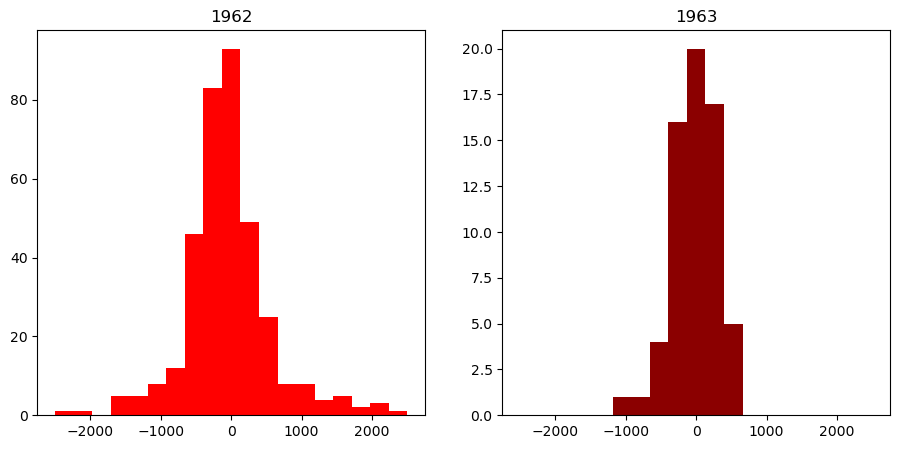

In [16]:
dists = []
skip_count = 0
total_count = 0
timestamps = [datetime.datetime(1962, 5, 16), datetime.datetime(1963, 8, 29)]
for timestamp in timestamps:
    dists_timestamp = []
    front_ids = kh_fronts.loc[kh_fronts.timestamp == timestamp].front_id.unique()
    for i_front_id, front_id in enumerate(front_ids):
        fronts = kh_fronts.loc[kh_fronts.front_id == front_id].loc[kh_fronts.timestamp == timestamp]
        for k in range(len(fronts.geometry) - 1):
            for l in range(k + 1, len(fronts.geometry)):
                front1 = fronts.geometry.iloc[k]
                front2 = fronts.geometry.iloc[l]
                dir_1 = fronts.front_dir.iloc[k]
                dir_2 = fronts.front_dir.iloc[l]
                if not boxes.loc[boxes.front_id == fronts.front_id.iloc[k]].empty:
                    box = boxes.loc[boxes.front_id == fronts.front_id.iloc[k]].geometry.values[0]
                    dist, e = distances.box_distance(front1, front2, box, dir_1, dir_2)
                    # if dist == np.nan:
                    #     print(f"Warning: NaN distance for front_id {front_id}, timestamp {timestamp}, indices {k}, {l}")
                    if dist is not None:
                        dists_timestamp.append(dist)
                    elif e == 1:
                        skip_count += 1
                else:
                    skip_count += 1
                total_count += 1
    dists.append(dists_timestamp)
        
dists_npy = [np.array(dists_timestamp) for dists_timestamp in dists]
sigma_kh = [dists_npy_timestamp.std() for dists_npy_timestamp in dists_npy]
mean = [dists_npy_timestamp.mean() for dists_npy_timestamp in dists_npy]

for i in range(len(timestamps)):
    print(f"Timestamp: {timestamps[i]}, Mean distance: {mean[i]:.2f} m, Standard deviation: {sigma_kh[i]:.2f} m")

print(f"Skipped {skip_count} comparisons out of {total_count}.")
fig, axs = plt.subplots(ncols=len(timestamps), figsize=(11, 5))
axs[0].hist(dists[0], bins=np.linspace(-2500, 2500, 20), color="red")
axs[0].set_title(timestamps[0].strftime("%Y"))
axs[1].hist(dists[1], bins=np.linspace(-2500, 2500, 20), color="darkred")
axs[1].set_title(timestamps[1].strftime("%Y"))
# fig.suptitle("Distribution of distances between KH-5 ARGON fronts")
fig.savefig("images/KH-5_ARGON_fonts_accuracy_box.png", bbox_inches="tight")

Year: 1976, Mean distance: -15.85 m, Standard deviation: 135.86 m
Year: 1978, Mean distance: -4.80 m, Standard deviation: 139.03 m
Skipped 108 comparisons out of 337.


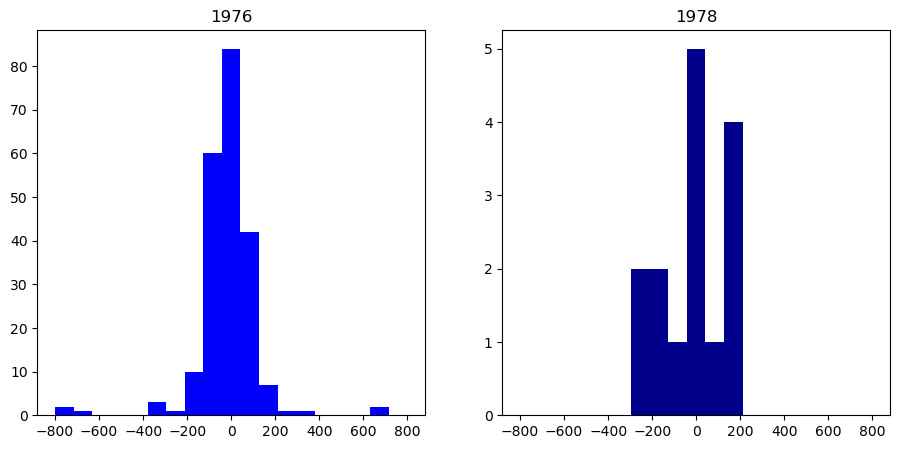

In [17]:
def get_year(timestamp):
    return timestamp.year

dists = []
skip_count = 0
total_count = 0
years = [1976, 1978]
for year in years:
    dists_year = []
    front_ids = landsat_fronts.loc[landsat_fronts.timestamp.apply(get_year) == year].front_id.unique()
    for front_id in front_ids:
        fronts = landsat_fronts.loc[landsat_fronts.front_id == front_id].loc[landsat_fronts.timestamp.apply(get_year) == year]
        for k in range(len(fronts.geometry) - 1):
            for l in range(k + 1, len(fronts.geometry)):
                front1 = fronts.geometry.iloc[k]
                front2 = fronts.geometry.iloc[l]
                dir_1 = fronts.front_dir.iloc[k]
                dir_2 = fronts.front_dir.iloc[l]
                if not boxes.loc[boxes.front_id == fronts.front_id.iloc[k]].empty:
                    box = boxes.loc[boxes.front_id == fronts.front_id.iloc[k]].geometry.values[0]
                    dist, e = distances.box_distance(front1, front2, box, dir_1, dir_2)
                    if dist is not None:
                        dists_year.append(dist)
                    elif e == 1:
                        skip_count += 1
                else:
                    skip_count += 1
                total_count += 1
    dists.append(dists_year)
        
dists_npy = [np.array(dists_year) for dists_year in dists]
sigma_landsat = [dists_npy_year.std() for dists_npy_year in dists_npy]
mean = [dists_npy_year.mean() for dists_npy_year in dists_npy]

for i in range(len(years)):
    print(f"Year: {years[i]}, Mean distance: {mean[i]:.2f} m, Standard deviation: {sigma_landsat[i]:.2f} m")

print(f"Skipped {skip_count} comparisons out of {total_count}.")
fig, axs = plt.subplots(ncols=len(years), figsize=(11, 5))
axs[0].hist(dists[0], bins=np.linspace(-800, 800, 20), color="blue")
axs[0].set_title(years[0])
axs[1].hist(dists[1], bins=np.linspace(-800, 800, 20), color="darkblue")
axs[1].set_title(years[1])
# fig.suptitle("Distribution of distances between Landsat MSS fronts")
fig.savefig("images/Landsat_MSS_fonts_accuracy_box.png", bbox_inches="tight")

In [18]:
years = np.array([1962, 1963, 1976, 1978])
sigmas_prime = np.floor(np.concatenate([sigma_kh, sigma_landsat]))
sigmas = np.floor(sigmas_prime / np.sqrt(2))
print(sigmas_prime, sigmas)

[710. 304. 135. 139.] [502. 214.  95.  98.]


In [24]:
uncertainties_box = pd.DataFrame(
    [],
    columns=["year_1", "year_2", "sigma_dist", "2_sigma_dist", "3_sigma_dist"]
)

for i in range(len(years) - 1):
    for j in range(i, len(years)):
        uncertainties_box.loc[len(uncertainties_box)] = [
            years[i],
            years[j],
            np.sqrt(sigmas[i]**2 + sigmas[j]**2),
            2 * np.sqrt(sigmas[i]**2 + sigmas[j]**2),
            3 * np.sqrt(sigmas[i]**2 + sigmas[j]**2)
        ]
        

uncertainties_box = uncertainties_box[["year_1", "year_2", "sigma_dist", "2_sigma_dist", "3_sigma_dist"]]
uncertainties_box

,year_1,year_2,sigma_dist,2_sigma_dist,3_sigma_dist
0,1962.0,1962.0,709.935208,1419.870417,2129.805625
1,1962.0,1963.0,545.710546,1091.421092,1637.131638
2,1962.0,1976.0,510.909973,1021.819945,1532.729918
3,1962.0,1978.0,511.476295,1022.952589,1534.428884
4,1963.0,1963.0,302.641702,605.283405,907.925107
5,1963.0,1976.0,234.138848,468.277695,702.416543
6,1963.0,1978.0,235.372046,470.744092,706.116138
7,1976.0,1976.0,134.350288,268.700577,403.050865
8,1976.0,1978.0,136.488095,272.976189,409.464284


In [25]:
uncertainties_box.to_csv("./uncertainties_box.csv", index=False)